# Introducción a YOLO

En este cuaderno se presentan las bases de YOLO, solo lo fundamental para preparar y entrenar un modelo que utilice segmentación de imagenes.

para esta prueba vamos a crear un dataset en donde se generen figuras geometricas en un fondo blanco, y entrenar el modelo de ultratics con transfer learning papra el entendimiento del modelo. una vez hecho realizaremos algunas pruebas.

### Generacion del dataset

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm

def draw_shape(img, shape, label_path, class_id):
    mask = np.zeros_like(img[:, :, 0])
    if shape == 'circle':
        center = (random.randint(80, 560), random.randint(80, 400))
        radius = random.randint(30, 60)
        cv2.circle(img, center, radius, (0, 255, 0), -1)
        cv2.circle(mask, center, radius, 255, -1)
    elif shape == 'square':
        x = random.randint(80, 480)
        y = random.randint(80, 320)
        size = random.randint(60, 100)
        pt1 = (x, y)
        pt2 = (x+size, y+size)
        cv2.rectangle(img, pt1, pt2, (255, 0, 0), -1)
        cv2.rectangle(mask, pt1, pt2, 255, -1)
    elif shape == 'triangle':
        pts = np.array([
            [random.randint(100, 500), random.randint(100, 400)],
            [random.randint(100, 500), random.randint(100, 400)],
            [random.randint(100, 500), random.randint(100, 400)]
        ])
        cv2.drawContours(img, [pts], 0, (0, 0, 255), -1)
        cv2.drawContours(mask, [pts], 0, 255, -1)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    with open(label_path, 'a') as f:
        for cnt in contours:
            if len(cnt) < 3:
                continue
            flat = cnt.flatten()
            norm = [str(x / 640 if i % 2 == 0 else x / 480) for i, x in enumerate(flat)]
            line = f"{class_id} " + " ".join(norm) + "\n"
            f.write(line)

shapes = ['circle', 'square', 'triangle']
os.makedirs('Test/images/train', exist_ok=True)
os.makedirs('Test/images/val', exist_ok=True)
os.makedirs('Test/labels/train', exist_ok=True)
os.makedirs('Test/labels/val', exist_ok=True)

for split in ['train', 'val']:
    for i in tqdm(range(200 if split == 'train' else 40)):
        img = np.ones((480, 640, 3), dtype=np.uint8) * 255
        label_path = f"Test/labels/{split}/{i}.txt"
        for _ in range(random.randint(1, 3)):
            shape = random.choice(shapes)
            class_id = shapes.index(shape)
            draw_shape(img, shape, label_path, class_id)
        cv2.imwrite(f"Test/images/{split}/{i}.jpg", img)


100%|██████████| 40/40 [00:00<00:00, 327.35it/s]


### Entrenamiento del modelo

Necesitamos un archivo .yaml que será el que le indique al modelo qué significan los valores de dato de cada una de las figuras que se mencionan en el archivo .txt dek dataset

In [ ]:
yaml_content = """\
train: images/train
val: images/val

nc: 3
names: ['circle', 'square', 'triangle']
"""

with open("Test/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ Archivo Test/data.yaml creado correctamente.")


✅ Archivo Test/data.yaml creado correctamente.


la forma en la que funcionan los archivos .txt e imagenes es la siguiente

por cada imagen, por ejemplo imagen1

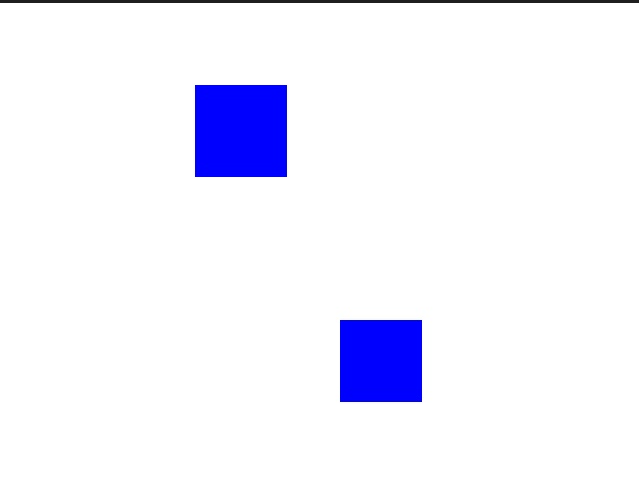

vamos a tener un archivo .txt cómo el siguiente, qué es en este caso el que le corresponde.

1 0.3046875 0.17083333333333334 0.3046875 0.36041666666666666 0.446875 0.36041666666666666 0.446875 0.17083333333333334
1 0.53125 0.6604166666666667 0.53125 0.8291666666666667 0.6578125 0.8291666666666667 0.6578125 0.6604166666666667


en donde, el primer valor indica a qué figura representa, en eeste caso 1, cuadrado para ambas figuras.

los siguientes valores indican posiciones en X y Y para cada uno de los vertices de la figura. en este caso podemos definirlos no como cuadrados para cada figura y que se identifique por contenido sino por sus vertices.

en caso de ser un triangulo solo existirian 3 puntos y su valor sería 2, y en caso de ser circulos su valor es mucho más grande por la cantidad de vertices de la figura.
un ejemplo de esto es el siguiente


en donde cada punto se ve representado y el valor inicial o figura de su label es 0

**0** 0.30625 0.5791666666666667 0.3046875 0.58125 0.290625 0.58125 0.2890625 0.5833333333333334 0.284375 0.5833333333333334 0.2828125 0.5854166666666667 0.278125 0.5854166666666667 0.2765625 0.5875 0.275 0.5875 0.2734375 0.5895833333333333 0.2703125 0.5895833333333333 0.26875 0.5916666666666667 0.2671875 0.5916666666666667 0.265625 0.59375 0.2640625 0.59375 0.2609375 0.5979166666666667 0.259375 0.5979166666666667 0.25625 0.6020833333333333 0.2546875 0.6020833333333333 0.25 0.6083333333333333 0.2484375 0.6083333333333333 0.240625 0.61875 0.240625 0.6208333333333333 0.2359375 0.6270833333333333 0.2359375 0.6291666666666667 0.2328125 0.6333333333333333 0.2328125 0.6354166666666666 0.2296875 0.6395833333333333 0.2296875 0.6416666666666667 0.228125 0.64375 0.228125 0.6458333333333334 0.2265625 0.6479166666666667 0.2265625 0.6520833333333333 0.225 0.6541666666666667 0.225 0.65625 0.2234375 0.6583333333333333 0.2234375 0.6645833333333333 0.221875 0.6666666666666666 0.221875 0.6729166666666667 0.2203125 0.675 0.2203125 0.69375 0.21875 0.6958333333333333 0.2203125 0.6979166666666666 0.2203125 0.7166666666666667 0.221875 0.71875 0.221875 0.725 0.2234375 0.7270833333333333 0.2234375 0.7333333333333333 0.225 0.7354166666666667 0.225 0.7375 0.2265625 0.7395833333333334 0.2265625 0.74375 0.228125 0.7458333333333333 0.228125 0.7479166666666667 0.2296875 0.75 0.2296875 0.7520833333333333 0.2328125 0.75625 0.2328125 0.7583333333333333 0.2359375 0.7625 0.2359375 0.7645833333333333 0.240625 0.7708333333333334 0.240625 0.7729166666666667 0.2484375 0.7833333333333333 0.25 0.7833333333333333 0.2546875 0.7895833333333333 0.25625 0.7895833333333333 0.259375 0.79375 0.2609375 0.79375 0.2640625 0.7979166666666667 0.265625 0.7979166666666667 0.2671875 0.8 0.26875 0.8 0.2703125 0.8020833333333334 0.2734375 0.8020833333333334 0.275 0.8041666666666667 0.2765625 0.8041666666666667 0.278125 0.80625 0.2828125 0.80625 0.284375 0.8083333333333333 0.2890625 0.8083333333333333 0.290625 0.8104166666666667 0.3046875 0.8104166666666667 0.30625 0.8125 0.3078125 0.8104166666666667 0.321875 0.8104166666666667 0.3234375 0.8083333333333333 0.328125 0.8083333333333333 0.3296875 0.80625 0.334375 0.80625 0.3359375 0.8041666666666667 0.3375 0.8041666666666667 0.3390625 0.8020833333333334 0.3421875 0.8020833333333334 0.34375 0.8 0.3453125 0.8 0.346875 0.7979166666666667 0.3484375 0.7979166666666667 0.3515625 0.79375 0.353125 0.79375 0.35625 0.7895833333333333 0.3578125 0.7895833333333333 0.3625 0.7833333333333333 0.3640625 0.7833333333333333 0.371875 0.7729166666666667 0.371875 0.7708333333333334 0.3765625 0.7645833333333333 0.3765625 0.7625 0.3796875 0.7583333333333333 0.3796875 0.75625 0.3828125 0.7520833333333333 0.3828125 0.75 0.384375 0.7479166666666667 0.384375 0.7458333333333333 0.3859375 0.74375 0.3859375 0.7395833333333334 0.3875 0.7375 0.3875 0.7354166666666667 0.3890625 0.7333333333333333 0.3890625 0.7270833333333333 0.390625 0.725 0.390625 0.71875 0.3921875 0.7166666666666667 0.3921875 0.6979166666666666 0.39375 0.6958333333333333 0.3921875 0.69375 0.3921875 0.675 0.390625 0.6729166666666667 0.390625 0.6666666666666666 0.3890625 0.6645833333333333 0.3890625 0.6583333333333333 0.3875 0.65625 0.3875 0.6541666666666667 0.3859375 0.6520833333333333 0.3859375 0.6479166666666667 0.384375 0.6458333333333334 0.384375 0.64375 0.3828125 0.6416666666666667 0.3828125 0.6395833333333333 0.3796875 0.6354166666666666 0.3796875 0.6333333333333333 0.3765625 0.6291666666666667 0.3765625 0.6270833333333333 0.371875 0.6208333333333333 0.371875 0.61875 0.3640625 0.6083333333333333 0.3625 0.6083333333333333 0.3578125 0.6020833333333333 0.35625 0.6020833333333333 0.353125 0.5979166666666667 0.3515625 0.5979166666666667 0.3484375 0.59375 0.346875 0.59375 0.3453125 0.5916666666666667 0.34375 0.5916666666666667 0.3421875 0.5895833333333333 0.3390625 0.5895833333333333 0.3375 0.5875 0.3359375 0.5875 0.334375 0.5854166666666667 0.3296875 0.5854166666666667 0.328125 0.5833333333333334 0.3234375 0.5833333333333334 0.321875 0.58125 0.3078125 0.58125


Para el entrenamiento solo se realiza la carga del modelo preentrenao para continuar con la idea de transfer-learning, y podemos continuar con las pruebas

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n-seg.pt') 

model.train(
    data='Test/data.yaml',
    epochs=30,
    imgsz=640,
    batch=8,
    task='segment'
)

Ultralytics 8.3.161  Python-3.10.11 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i7-12650H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Test/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

train: Scanning C:\Users\jorge\Documents\IA_FINAL\Test\labels\train.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: Fast image access  (ping: 0.00.0 ms, read: 143.071.5 MB/s, size: 11.7 KB)



c:\Users\jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\jorge\Documents\IA_FINAL\Test\labels\val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]

Plotting labels to runs\segment\train5\labels.jpg... 



c:\Users\jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\segment\train5
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G     0.7889      1.772      2.549     0.9769         24        640: 100%|██████████| 25/25 [00:40<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all         40         81    0.00576      0.858      0.539       0.45    0.00574       0.85      0.522      0.391

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       2/30         0G     0.6515      1.386      1.356     0.9462         32        640: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         40         81          1     0.0998      0.787      0.657      0.946     0.0863      0.735      0.599

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       3/30         0G     0.6626      1.235      1.191     0.9474         31        640: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         40         81      0.807      0.364      0.855      0.718      0.784      0.314       0.81      0.665

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       4/30         0G     0.6734      1.212       1.21     0.9585         34        640: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         40         81      0.744      0.832      0.871      0.743      0.739      0.817      0.889      0.714

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       5/30         0G     0.6954      1.219      1.169     0.9591         22        640: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         40         81      0.898      0.851      0.903      0.753      0.886      0.804      0.866      0.713

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       6/30         0G     0.6404      1.023      1.042     0.9306         22        640: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         40         81      0.931      0.823      0.868      0.752      0.827      0.827      0.836      0.677

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       7/30         0G     0.5946     0.9742     0.9288     0.9201         38        640: 100%|██████████| 25/25 [00:41<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all         40         81       0.92      0.891      0.911      0.814       0.93      0.926      0.938      0.755



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G     0.6088      1.151     0.9143     0.9355         29        640: 100%|██████████| 25/25 [00:41<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all         40         81      0.916      0.916      0.929      0.813      0.903      0.889        0.9      0.743

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       9/30         0G     0.5449      0.921     0.8512     0.9127         24        640: 100%|██████████| 25/25 [00:41<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all         40         81       0.87      0.916      0.905       0.83      0.879      0.933      0.927      0.724

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      10/30         0G     0.5238     0.9961     0.8444     0.8971         20        640: 100%|██████████| 25/25 [00:41<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all         40         81      0.932      0.903      0.917      0.843      0.937      0.907      0.931      0.735

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      11/30         0G     0.4974     0.8661     0.7786     0.8883         20        640: 100%|██████████| 25/25 [00:41<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

                   all         40         81      0.896      0.924      0.925       0.85      0.949      0.904      0.942      0.756

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      12/30         0G     0.5196     0.9474     0.7865     0.9057         33        640: 100%|██████████| 25/25 [00:41<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all         40         81      0.899       0.94      0.901      0.837      0.924      0.952      0.948      0.748

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      13/30         0G     0.5015     0.9347      0.751      0.892         31        640: 100%|██████████| 25/25 [00:42<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all         40         81      0.937      0.884      0.903      0.836      0.938      0.909      0.925      0.743

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      14/30         0G     0.5243     0.8984     0.7403     0.9039         33        640: 100%|██████████| 25/25 [00:41<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all         40         81       0.91      0.886      0.921      0.851      0.908       0.91      0.935      0.775



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G     0.4975        0.9     0.7082     0.9022         32        640: 100%|██████████| 25/25 [00:41<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all         40         81      0.948      0.862      0.921      0.855       0.92      0.952      0.948      0.776



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G     0.4751     0.8807     0.6957     0.8948         36        640: 100%|██████████| 25/25 [00:41<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all         40         81      0.893      0.937      0.911       0.85       0.91      0.958      0.929      0.754

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      17/30         0G     0.4712     0.8274     0.6889      0.891         20        640: 100%|██████████| 25/25 [00:41<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all         40         81      0.951      0.866      0.935      0.872      0.945      0.888      0.932      0.767

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      18/30         0G     0.4681     0.7968     0.6385     0.8962         25        640: 100%|██████████| 25/25 [00:41<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all         40         81       0.91      0.905      0.941      0.841      0.915       0.91      0.934       0.77

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      19/30         0G     0.4488     0.8078     0.6279     0.8816         30        640: 100%|██████████| 25/25 [00:42<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all         40         81      0.904      0.921      0.941      0.892      0.904      0.921      0.955      0.775

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      20/30         0G     0.4276      0.763     0.6233     0.8758         32        640: 100%|██████████| 25/25 [00:41<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all         40         81      0.955      0.917      0.942      0.888      0.942      0.905      0.932      0.775
Closing dataloader mosaic



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
      21/30         0G     0.3779     0.7987     0.6601     0.8474         17        640: 100%|██████████| 25/25 [00:42<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all         40         81      0.962      0.916      0.949      0.887      0.949      0.903      0.934      0.776

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      22/30         0G     0.3793     0.6906     0.6619     0.8439         17        640: 100%|██████████| 25/25 [00:43<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

                   all         40         81      0.972      0.917      0.955      0.894      0.941      0.912      0.938      0.781

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      23/30         0G     0.3523     0.6761     0.6365      0.844         15        640: 100%|██████████| 25/25 [00:41<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all         40         81      0.982      0.899       0.96      0.889      0.977      0.922      0.951      0.783

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      24/30         0G     0.3589     0.6673     0.6277     0.8439         13        640: 100%|██████████| 25/25 [00:41<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all         40         81      0.993      0.932      0.966      0.901      0.993      0.932      0.979       0.78



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G     0.3568     0.6639     0.6158       0.86         15        640: 100%|██████████| 25/25 [00:40<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all         40         81      0.973      0.936      0.965      0.904      0.989      0.935      0.977      0.781

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      26/30         0G     0.3396     0.6636     0.6039     0.8377         13        640: 100%|██████████| 25/25 [00:41<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all         40         81      0.972      0.937      0.965      0.892      0.958      0.957      0.961       0.79

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      27/30         0G     0.3208     0.6369     0.5659     0.8313         17        640: 100%|██████████| 25/25 [00:41<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all         40         81      0.977      0.935      0.966      0.897      0.945      0.974      0.963      0.796

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      28/30         0G     0.3265      0.622     0.5819     0.8413         17        640: 100%|██████████| 25/25 [00:41<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all         40         81      0.978      0.934      0.965       0.91      0.978      0.951      0.968      0.799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G     0.2965     0.5519      0.561     0.8251         15        640: 100%|██████████| 25/25 [00:41<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all         40         81      0.977      0.937      0.963      0.905      0.977      0.968      0.975      0.799

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      30/30         0G     0.2926     0.5628      0.548     0.8126         17        640: 100%|██████████| 25/25 [00:40<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all         40         81      0.962      0.924      0.962      0.904      0.977      0.965      0.975      0.804

30 epochs completed in 0.365 hours.


Optimizer stripped from runs\segment\train5\weights\last.pt, 6.8MB
Optimizer stripped from runs\segment\train5\weights\best.pt, 6.8MB

Validating runs\segment\train5\weights\best.pt...
Ultralytics 8.3.161  Python-3.10.11 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i7-12650H)
YOLOv8n-seg summary (fused): 85 layers, 3,258,649 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


                   all         40         81      0.978      0.934      0.965      0.912      0.978      0.951      0.968      0.802
                circle         20         27          1      0.999      0.995      0.984      0.998          1      0.995      0.864
                square         25         34       0.99      0.971      0.994      0.988      0.988      0.971      0.994      0.834
              triangle         17         20      0.943      0.833      0.905      0.763      0.946      0.883      0.915      0.708
Speed: 0.6ms preprocess, 52.9ms inference, 0.0ms loss, 12.0ms postprocess per image
Results saved to runs\segment\train5


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000029E1EA7A8C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    

### Validar y visualizar resultados.

Dado a problemas con matplotlib, estoy utilizando openCV para la carga y visualizacización de imagenes.

In [33]:


import matplotlib.pyplot as plt
import cv2

results = model.predict(source="Test/images/val/0.jpg", save=False, show=False, task="segment")

img_with_boxes = results[0].plot()
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

cv2.imshow('Predicción', img_with_boxes)
cv2.waitKey(0)
cv2.destroyAllWindows()


image 1/1 c:\Users\jorge\Documents\IA_FINAL\Test\images\val\0.jpg: 480x640 1 circle, 1 square, 69.6ms
Speed: 1.8ms preprocess, 69.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Cargo la imagen manualmente para que se vea el ejemplo con el modelo ya entrenado

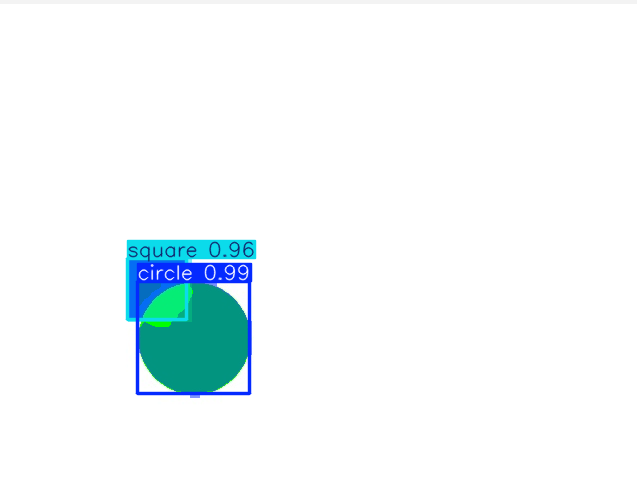

In [37]:
results = model.predict(source="Test/images/val/5.jpg", save=False, show=False, task="segment")

img_with_boxes = results[0].plot()
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

cv2.imshow('Predicción', img_with_boxes)
cv2.waitKey(0)
cv2.destroyAllWindows()


image 1/1 c:\Users\jorge\Documents\IA_FINAL\Test\images\val\5.jpg: 480x640 2 circles, 1 square, 68.8ms
Speed: 1.1ms preprocess, 68.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


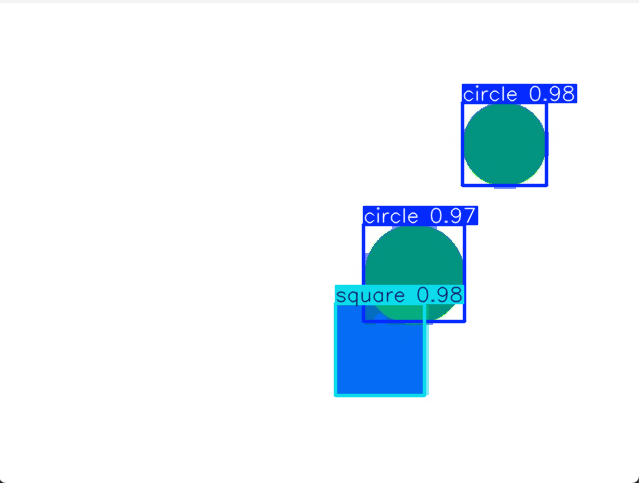

In [38]:
results = model.predict(source="Test/images/val/27.jpg", save=False, show=False, task="segment")

img_with_boxes = results[0].plot()
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

cv2.imshow('Predicción', img_with_boxes)
cv2.waitKey(0)
cv2.destroyAllWindows()


image 1/1 c:\Users\jorge\Documents\IA_FINAL\Test\images\val\27.jpg: 480x640 2 squares, 1 triangle, 63.5ms
Speed: 1.2ms preprocess, 63.5ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


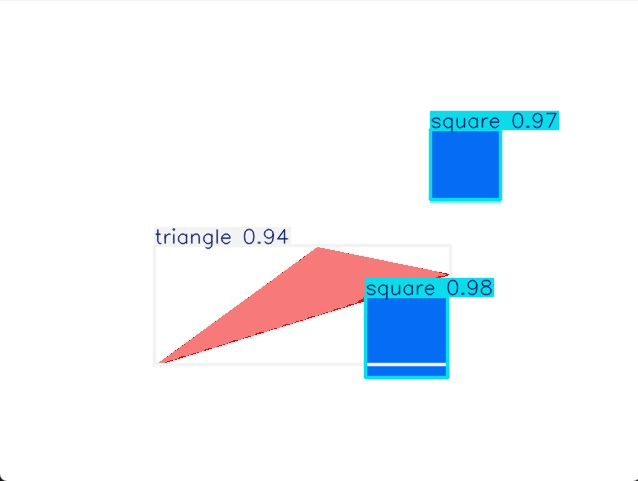

In [47]:
modelCargado  = YOLO("runs/segment/train5/weights/best.pt")

In [48]:
results = model.predict(source="Test/images/val/27.jpg", save=False, show=False, task="segment")

img_with_boxes = results[0].plot()
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

cv2.imshow('Predicción', img_with_boxes)
cv2.waitKey(0)
cv2.destroyAllWindows()


image 1/1 c:\Users\jorge\Documents\IA_FINAL\Test\images\val\27.jpg: 480x640 2 squares, 1 triangle, 91.8ms
Speed: 1.6ms preprocess, 91.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)
